In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/attention_flow

/content/gdrive/MyDrive/attention_flow


In [3]:
!pip install transformers

In [4]:
import numpy as np
import tensorflow_datasets as tfds
from attention_graph_util import *

import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally

In [5]:
!ls

attention_graph_util.py		 correlation_logs	 rat_bert_att_2.png	 run_bert_sv.py
bert_example.ipynb		 distilbert_sst.ipynb	 rat_bert_bar_2.png	 utils
bert_sv.ipynb			 distill_bert_viz.ipynb  README.md
bert_viz.ipynb			 graphs			 res_fat_bert_att_2.png
compute_corel_distilbert_sst.py  __pycache__		 res_jat_bert_att_2.png


In [6]:
import torch
from transformers import *

# Transformers has a unified API
# for 8 transformer architectures and 30 pretrained weights.
#          Model          | Tokenizer          | Pretrained weights shortcut
MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased'),
          (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
          (GPT2Model,       GPT2Tokenizer,       'gpt2'),
          (CTRLModel,       CTRLTokenizer,       'ctrl'),
          (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
          (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
          (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
          (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased'),
          (RobertaModel,    RobertaTokenizer,    'roberta-base')]

GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


In [7]:
# Each architecture is provided with several class for fine-tuning on down-stream tasks, e.g.
BERT_MODEL_CLASSES = [BertModel, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction,
                      BertForSequenceClassification, BertForTokenClassification, BertForQuestionAnswering]

# All the classes for an architecture can be initiated from pretrained weights for this architecture
# Note that additional weights added for fine-tuning are only initialized
# and need to be trained on the down-stream task
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /roo

In [8]:
model = BertModel.from_pretrained(pretrained_weights,
                                    output_hidden_states=True,
                                    output_attentions=True)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a

In [9]:
sentence = "He said his last words"
sentence = "James Cook was a nice person and a good husband"
sentence = "The horse raced past the barn fell"
tokens = ['cls']+tokenizer.tokenize(sentence)+['sep']
print(len(tokens))
input_ids = torch.tensor([tokenizer.encode(sentence)])
all_hidden_states, all_attentions = model(input_ids)[-2:]

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


9
(12, 12, 9, 9)


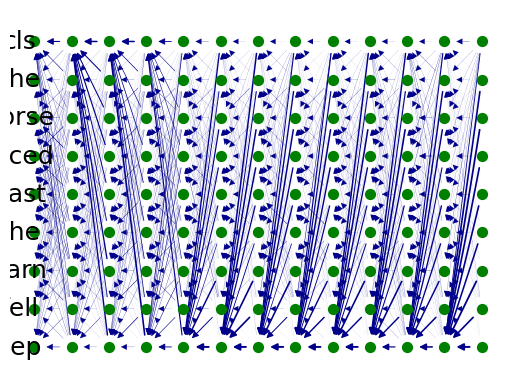

In [10]:
att_mat = attentions_mat.sum(axis=1)/8
adj_mat, labels_to_index = get_adjmat(mat=att_mat, input_tokens=tokens)

G = draw_attention_graph(adj_mat,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('rat_bert.png', format='png', transparent=True, dpi=760)

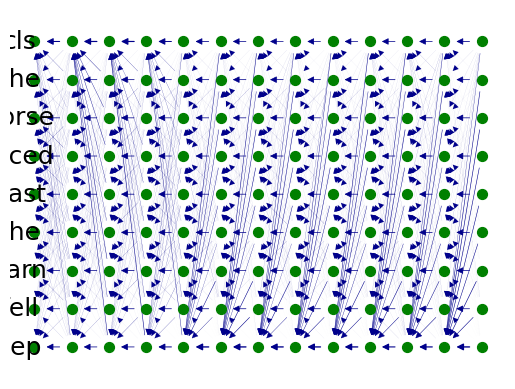

In [12]:
res_att_mat = attentions_mat.sum(axis=1)/12
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
plt.savefig('res_rat_bert.png', format='png', transparent=True, dpi=760)

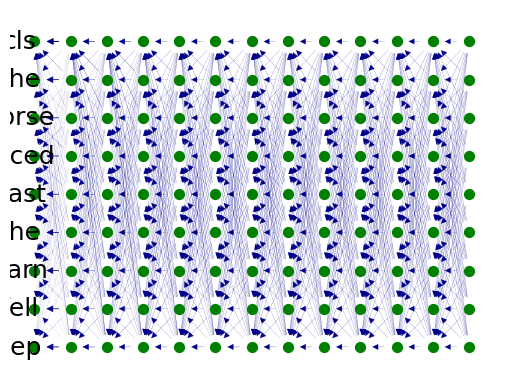

In [13]:
output_nodes = []
input_nodes = []
for key in labels_to_index:
    if 'L6' in key:
        output_nodes.append(key)
    if labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])

flow_G = draw_attention_graph(flow_values,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('res_fat_bert.png', format='png', transparent=True, dpi=760)

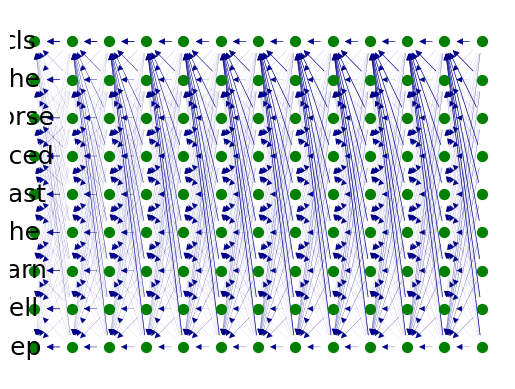

In [14]:
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)

G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
plt.savefig('res_jat_bert.png', format='png', transparent=True, dpi=760)

In [15]:
data = tfds.load('glue/mrpc')

# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task='mrpc')
valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task='mrpc')
train_dataset = train_dataset.shuffle(100).batch(32).repeat(10)
valid_dataset = valid_dataset.batch(64)

valid_iter = iter(valid_dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3668 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/incomplete.6I93KJ_2.0.0/glue-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/408 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/incomplete.6I93KJ_2.0.0/glue-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/1725 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/incomplete.6I93KJ_2.0.0/glue-test.tfrecord*...:   0%|          |…

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.11/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.11/dist-packages/transformers/data/processors/glue.py:174: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Using label list ['0', '1'] for task mrpc
Using output mode classification for task mrpc
*** Example ***
guid: 1680

In [17]:
data = tfds.load('glue/sst2')

# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task='sst-2')
valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task='sst-2')
train_dataset = train_dataset.shuffle(100).batch(32).repeat(10)
valid_dataset = valid_dataset.batch(64)

valid_iter = iter(valid_dataset)

/usr/local/lib/python3.11/dist-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Using label list ['0', '1'] for task sst-2
Using output mode classification for task sst-2
*** Example ***
guid: 16399
features: InputFeatures(input_ids=[101, 2005, 1996, 4895, 5498, 10711, 3064, 3248, 2488, 2006, 2678, 2007, 1996, 2614, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [18]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, epochs=10, steps_per_epoch=115,
                    validation_data=valid_dataset, validation_steps=7)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Loaded 109,482,240 parameters i

Epoch 1/10
115/115 [==============================] - 159s 863ms/step - loss: 0.3713 - accuracy: 0.8313 - val_loss: 0.2954 - val_accuracy: 0.8839
Epoch 2/10
115/115 [==============================] - 95s 827ms/step - loss: 0.2709 - accuracy: 0.8902 - val_loss: 0.2282 - val_accuracy: 0.9085
Epoch 3/10
115/115 [==============================] - 94s 815ms/step - loss: 0.2516 - accuracy: 0.8976 - val_loss: 0.2418 - val_accuracy: 0.9040
Epoch 4/10
115/115 [==============================] - 95s 825ms/step - loss: 0.2163 - accuracy: 0.9179 - val_loss: 0.2490 - val_accuracy: 0.9129
Epoch 5/10
115/115 [==============================] - 94s 814ms/step - loss: 0.1998 - accuracy: 0.9250 - val_loss: 0.2072 - val_accuracy: 0.9263
Epoch 6/10
115/115 [==============================] - 94s 814ms/step - loss: 0.1948 - accuracy: 0.9236 - val_loss: 0.2142 - val_accuracy: 0.9263
Epoch 7/10
115/115 [==============================] - 95s 825ms/step - loss: 0.2054 - accuracy: 0.9226 - val_loss: 0.2059 - val_a

In [19]:
x,y = valid_iter.next()
print(x['input_ids'][0])


tf.Tensor(
[  101  1037  3643  3238 25358  2666  6643 11219  2000  4013  3455  2104
 15773  2011  1996  6452  1012   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)


In [20]:
# Load the TensorFlow model in PyTorch for inspection
model.save_pretrained('save/')


Configuration saved in save/config.json
Model weights saved in save/tf_model.h5


In [21]:
pytorch_model = BertForSequenceClassification.from_pretrained('save/', from_tf=True, output_hidden_states=True,
                                    output_attentions=True)

loading configuration file save/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file save/tf_model.h5
Loading TensorFlow weights from save/tf_model.h5
All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification

In [22]:
# Quickly test a few predictions - MRPC is a paraphrasing task, let's see if our model learned the task
sentence_0 = "This research was consistent with his findings."
sentence_1 = "His findings were compatible with this research."
sentence_2 = "His findings were not consistent with this research."
inputs_1 = tokenizer.encode_plus(sentence_0, sentence_1, add_special_tokens=True, return_tensors='pt')
inputs_2 = tokenizer.encode_plus(sentence_0, sentence_2, add_special_tokens=True, return_tensors='pt')

pred_1 = pytorch_model(inputs_1['input_ids'], token_type_ids=inputs_1['token_type_ids'])[0].argmax().item()
pred_2 = pytorch_model(inputs_2['input_ids'], token_type_ids=inputs_2['token_type_ids'])[0].argmax().item()

print("sentence_1 is", "a paraphrase" if pred_1 else "not a paraphrase", "of sentence_0")
print("sentence_2 is", "a paraphrase" if pred_2 else "not a paraphrase", "of sentence_0")

sentence_1 is a paraphrase of sentence_0
sentence_2 is not a paraphrase of sentence_0


In [23]:
sentence_0 = "I saw the trailer peeking through the window"

sentence_0 = "This is a good pie"
sentence_1 = "This is tasty"
sentence_1 = "It tastes good"
sentence_2 = "this cake tastes bad"

sentence_0 = "I saw it peeking through the window"
sentence_1 = "I was peeking when I saw it"
sentence_2 = "It was peeking through the window"


tokens_1 = ['cls']+tokenizer.tokenize(sentence_0)+['sep']+tokenizer.tokenize(sentence_1)+['sep']
print(len(tokens_1))
inputs_1 = tokenizer.encode_plus(sentence_0, sentence_1, add_special_tokens=True, return_tensors='pt')

tokens_2 = ['cls']+tokenizer.tokenize(sentence_0)+['sep']+tokenizer.tokenize(sentence_2)+['sep']
print(len(tokens_1))
inputs_2 = tokenizer.encode_plus(sentence_0, sentence_2, add_special_tokens=True, return_tensors='pt')

outputs_1 = pytorch_model(inputs_1['input_ids'], token_type_ids=inputs_1['token_type_ids'])
pred_1 = outputs_1[0].argmax().item()
print("prediction:", bool(pred_1))

outputs_2 = pytorch_model(inputs_2['input_ids'], token_type_ids=inputs_2['token_type_ids'])
pred_2 = outputs_2[0].argmax().item()
print("prediction:", bool(pred_2))

all_hidden_states, all_attentions = outputs_1[-2:]
_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

17
17
prediction: False
prediction: False
(12, 12, 17, 17)


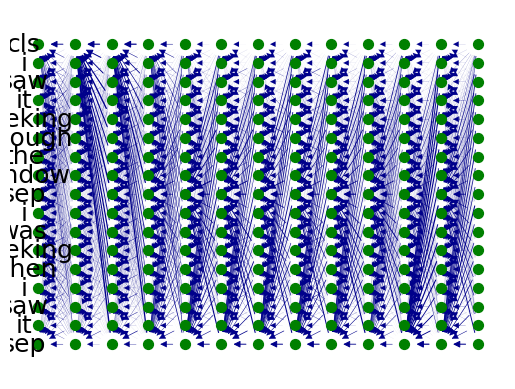

In [24]:
att_mat = attentions_mat.sum(axis=1)/8
adj_mat, labels_to_index = get_adjmat(mat=att_mat, input_tokens=tokens_1)

G = draw_attention_graph(adj_mat,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.margins(0.06)
plt.savefig('rat_bert_mrpc.pdf', format='pdf', transparent=True, dpi=360)

In [25]:
att_mat[-1][0]

array([0.06387889, 0.06133402, 0.10817425, 0.09510137, 0.06869552,
       0.02396655, 0.06519128, 0.11304908, 0.2314451 , 0.05224913,
       0.036377  , 0.11500213, 0.05264845, 0.04441827, 0.04770593,
       0.07162808, 0.24913496], dtype=float32)

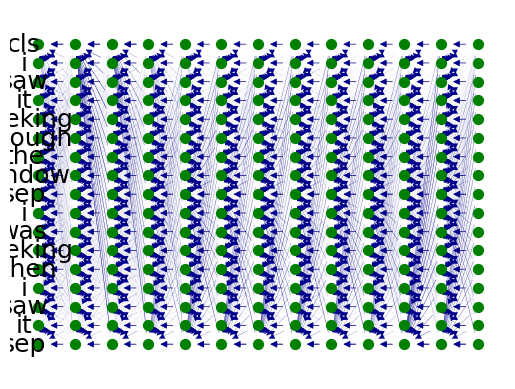

In [26]:
res_att_mat = attentions_mat.sum(axis=1)/12
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens_1)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
plt.margins(0.06)
plt.savefig('res_rat_bert_mrpc.pdf', format='pdf', transparent=True, dpi=360)

In [ ]:
output_nodes = []
input_nodes = []
for key in labels_to_index:
    if 'L6' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])
plt.margins(0.06)
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('res_fat_bert_mrpc.pdf', format='pdf', transparent=True, dpi=360)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-8384bc21562d>", line 9, in <cell line: 0>
    flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/gdrive/MyDrive/attention_flow/attention_graph_util.py", line 82, in compute_flows
    flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<class 'networkx.utils.decorators.argmap'> compilation 16", line 3, in argmap_maximum_flow_value_13
    import gzip
            ^^^^
  File "/usr/local/lib/python3.11/dist-packages/networkx/utils/backends.py", line 1355, in __call__
    ret

In [27]:
l = 14
d = 12
flow_values[d*l:, (d-1)*l: d*l][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens_1)

plt.margins(0.06)
G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
plt.savefig('res_jat_bert_mrpc.pdf', format='pdf', transparent=True, dpi=360)

In [ ]:
joint_attentions[-1][0]

In [ ]:
for x,y in zip(tokens_1, joint_attentions[-1][0]):
    print("("+x+","+str(y)+")")

','.join(tokens_1)

In [ ]:
for x,y in zip(tokens_1, att_mat[-1][0]):
    print("("+x+","+str(y)+")")

','.join(tokens_1)

In [ ]:
l = 14
d = 12
for x,y in zip(tokens_1,flow_values[d*l:, (d-1)*l: d*l][0]):
    print("("+x+","+str(y)+")")

','.join(tokens_1)